In [1]:
import sys
import polars as pl
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

current_dir = Path.cwd()
src_path = current_dir.parent / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))
    
from config import FEATURES_OUTPUT_DIR

### Data Preparation

In [2]:
feature_file = FEATURES_OUTPUT_DIR / "features_2010.parquet"
df = pl.read_parquet(feature_file)

In [3]:
# Aggregate to Market Level using median
market_features = (
    df.group_by("timestamp")
    .agg([
        pl.col("R_tau").median().alias("fragility"),
        pl.col("volatility").median().alias("volatility"),
        pl.col("avg_spread").median().alias("liquidity"),
        pl.col("trade_count").sum().alias("volume"),
        pl.col("mid_5m").median().alias("mid_5m"),
        pl.col("ret_5m").median().alias("ret_5m"),
    ])
    .sort("timestamp")
    .drop_nulls()
)


In [4]:
pdf = market_features.to_pandas()
pdf.set_index("timestamp", inplace=True)

# Could have included ret_5m but no time and space to do so
FEATURE_COLS = ["fragility", "volatility", "liquidity", "volume"] 
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pdf[FEATURE_COLS])
pdf_scaled = pd.DataFrame(X_scaled, columns=FEATURE_COLS, index=pdf.index)

pdf_scaled['mid_5m'] = pdf["mid_5m"]

In [5]:
pdf_scaled.head()

,fragility,volatility,liquidity,volume,mid_5m
timestamp,,,,,
2010-01-04 14:35:00,-0.354284,0.720810,0.168767,0.798023,46.880
2010-01-04 14:40:00,-0.345423,0.185609,-0.161109,0.585497,47.085
2010-01-04 14:45:00,-0.135888,0.090317,-0.149936,0.466054,46.995
2010-01-04 14:50:00,-0.054417,0.004124,-0.173948,0.217223,46.925
2010-01-04 14:55:00,-0.094940,-0.167816,-0.165281,0.099466,47.035


In [6]:
mid = pdf["mid_5m"].astype(float)

k = 2
drop = (mid.shift(-k) - mid) / mid

print("Worst 10-min drop:", drop.min())
print("Worst 10-min drop time:", drop.idxmin())

Worst 10-min drop: -0.04884683619160271
Worst 10-min drop time: 2010-05-24 15:55:00


In [7]:
t = pd.Timestamp("2010-05-24 15:55:00")
print(pdf.loc[t:t+pd.Timedelta("40min"), ["mid_5m", "liquidity", "fragility"]])

                     mid_5m  liquidity  fragility
timestamp                                        
2010-05-24 15:55:00  42.275   0.013333  -0.061389


In [8]:
import numpy as np

def crash_and_flashcrash_filter(
    df,
    method: str = "m1",
    z_col: str = "fragility_score",
    z_th: float = 3.0,
    anomaly_col: str = "anomaly_score",
    thr_col: str = "threshold",
    cluster_col: str = "cluster",
    crash_cluster_id: int | None = None,
    mid_col: str = "mid_5m",
    k: int = 2,
    m: int = 6,
    drop_th: float = -0.03,
    recovery_frac: float = 0.1,
    out_anom_col: str = "is_anomaly",
    out_drop_col: str = "drop_k",
    out_rec_col: str = "recovery_frac",
    out_candidate_col: str = "crash_candidate",
    out_flash_col: str = "flashcrash_confirmed",
):
    
    df = df.sort_index().copy()

    # Stage 0: anomaly flag (method-specific)
    if method == "m1":
        df[out_anom_col] = df[z_col].abs() > z_th

    elif method == "m2":
        df[out_anom_col] = df[anomaly_col] > df[thr_col]

    elif method == "m3":
        if crash_cluster_id is None:
            raise ValueError("For method 3, you must pass crash_cluster_id.")
        df[out_anom_col] = df[cluster_col] == crash_cluster_id

    else:
        raise ValueError("method must be one of: 'm1', 'm2', 'm3'")
    
    # Stage 1: crash candidate (drop-only) using mid
    mid = df[mid_col].astype(float)
    p_t = mid
    p_tk = mid.shift(-k)
    p_tm = mid.shift(-m)

    has_future_k = p_tk.notna()
    has_future_m = p_tm.notna()

    drop = (p_tk - p_t) / p_t
    df[out_drop_col] = drop

    df[out_candidate_col] = df[out_anom_col] & has_future_k & (drop < drop_th)

    # Stage 2: flash crash confirmation (recovery + optional liquidity shock)
    den = (p_t - p_tk)
    valid_drop = den > 0

    recovery = (p_tm - p_tk) / den
    recovery = recovery.where(valid_drop).replace([np.inf, -np.inf], np.nan)
    df[out_rec_col] = recovery

    flash = df[out_candidate_col] & has_future_m & (recovery > recovery_frac)
    df[out_flash_col] = flash

    candidates = df[df[out_candidate_col]]

    return df, candidates

1. Anomaly Detection: Before analyzing price action, the function flags rows as "anomalies" using one of three user-selected methods:<br>
Method 1 (Univariate Thresholding): Flags the row if the absolute value of fragility score exceeds threshold. <br>
Method 2 (Multivariate Threshold): Flags the row if a specific anomaly_score exceeds a dynamic threshold column.<br>
Method 3 (Clustering): Flags the row if the cluster_col matches the specific crash_cluster_id.

2. Crash Candidate Identification: This stage identifies significant price drops that coincide with an anomaly flag. It looks forward $k$ periods (default 10 minutes, assuming 5-min bars). The drop metric is calculated as:$$Drop_k = \frac{P_{t+k} - P_t}{P_t}$$Criteria for a Crash Candidate:<br>
Is Anomaly: The row was flagged in Anomaly Detection. <br>
Data Exists: Future price $P_{t+k}$ is available.<br>
Significant Drop: $Drop_k$ is lower than drop_threshold.

3. Flash Crash Confirmation: This stage differentiates a sustained crash from a "flash crash" by analyzing price recovery over a longer horizon $m$ (default 30 minutes). It measures how much of the initial drop was recovered. The recovery fraction is calculated as:$$Recovery = \frac{P_{t+m} - P_{t+k}}{P_t - P_{t+k}}$$ <br>
Criteria for a Flash Crash: <br>
Is Candidate: The row is already a Crash Candidate from Stage 1. <br>
Data Exists: Future price $P_{t+m}$ is available. <br>
Rebound: The $Recovery$ fraction is greater than recovery_frac (e.g., $>0.1$ implies more than 10% of the drop was recovered).

### Method 1 - Univariate Thresholding

In [49]:
def compute_fragility_scores(
    pdf: pd.DataFrame,
    col: str = "fragility",
    strategy: str = "rolling",
    window: int = 390,
    min_periods: int | None = None,  
    shift: int = 1, 
):
    out = pdf.copy()

    if min_periods is None:
        # We need minimum amount of history
        min_periods = max(30, window // 5) if strategy in {"rolling", "rolling_robust", "rolling_quantile"} else 30

    x = out[col]

    if strategy == "global":
        mu = x.mean()
        sd = x.std(ddof=0)
        out["fragility_score"] = (x - mu) / (sd if sd != 0 else np.nan)
        out["score_type"] = "z_global"
        out["threshold"] = np.nan

    elif strategy == "rolling":
        mu = x.rolling(window=window, min_periods=min_periods).mean().shift(shift)
        sd = x.rolling(window=window, min_periods=min_periods).std(ddof=0).shift(shift)
        out["fragility_score"] = (x - mu) / sd
        out["score_type"] = "z_rolling"
        out["threshold"] = np.nan

    elif strategy == "expanding":
        mu = x.expanding(min_periods=min_periods).mean().shift(shift)
        sd = x.expanding(min_periods=min_periods).std(ddof=0).shift(shift)
        out["fragility_score"] = (x - mu) / sd
        out["score_type"] = "z_expanding"
        out["threshold"] = np.nan

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    return out

In [53]:
def method1(
    pdf: pd.DataFrame,
    strategy: str = "rolling",
    sigma_warn: float = 3.0,
    sigma_alarm: float = 5.0,
    **kwargs,
):
    scored = compute_fragility_scores(pdf, strategy=strategy, **kwargs)

    if strategy == "rolling_quantile":
        # Outliers: value > rolling threshold
        outliers_warn = scored[scored["fragility_score"] > scored["threshold"]]
        outliers_alarm = outliers_warn

    else:
        # Outliers by z-score
        z = scored["fragility_score"]
        outliers_warn_pos = scored[z > sigma_warn]
        outliers_alarm_pos = scored[z > sigma_alarm]
        outliers_warn_neg = scored[z < -1 * sigma_warn]
        outliers_alarm_neg = scored[z < -1 * sigma_alarm]

    return scored, outliers_warn_pos, outliers_alarm_pos, outliers_warn_neg, outliers_alarm_neg

Strategy global
M1 candidates: 5
                     fragility  mid_5m    drop_k  recovery_frac
timestamp                                                      
2010-05-06 15:50:00  -0.018915  45.315 -0.030895       0.121429
2010-05-13 15:50:00   0.024600  46.605 -0.045918       0.313084
2010-05-20 15:50:00   0.063921  42.105 -0.040791       0.930131
2010-05-24 15:50:00  -0.069375  42.275 -0.047191       0.238095
2010-05-24 15:55:00  -0.061389  42.275 -0.048847       0.266344
----------------------
Strategy rolling
M1 candidates: 5
                     fragility  mid_5m    drop_k  recovery_frac
timestamp                                                      
2010-05-06 15:50:00  -0.018915  45.315 -0.030895       0.121429
2010-05-13 15:50:00   0.024600  46.605 -0.045918       0.313084
2010-05-20 15:50:00   0.063921  42.105 -0.040791       0.930131
2010-05-24 15:50:00  -0.069375  42.275 -0.047191       0.238095
2010-05-24 15:55:00  -0.061389  42.275 -0.048847       0.266344
--------------

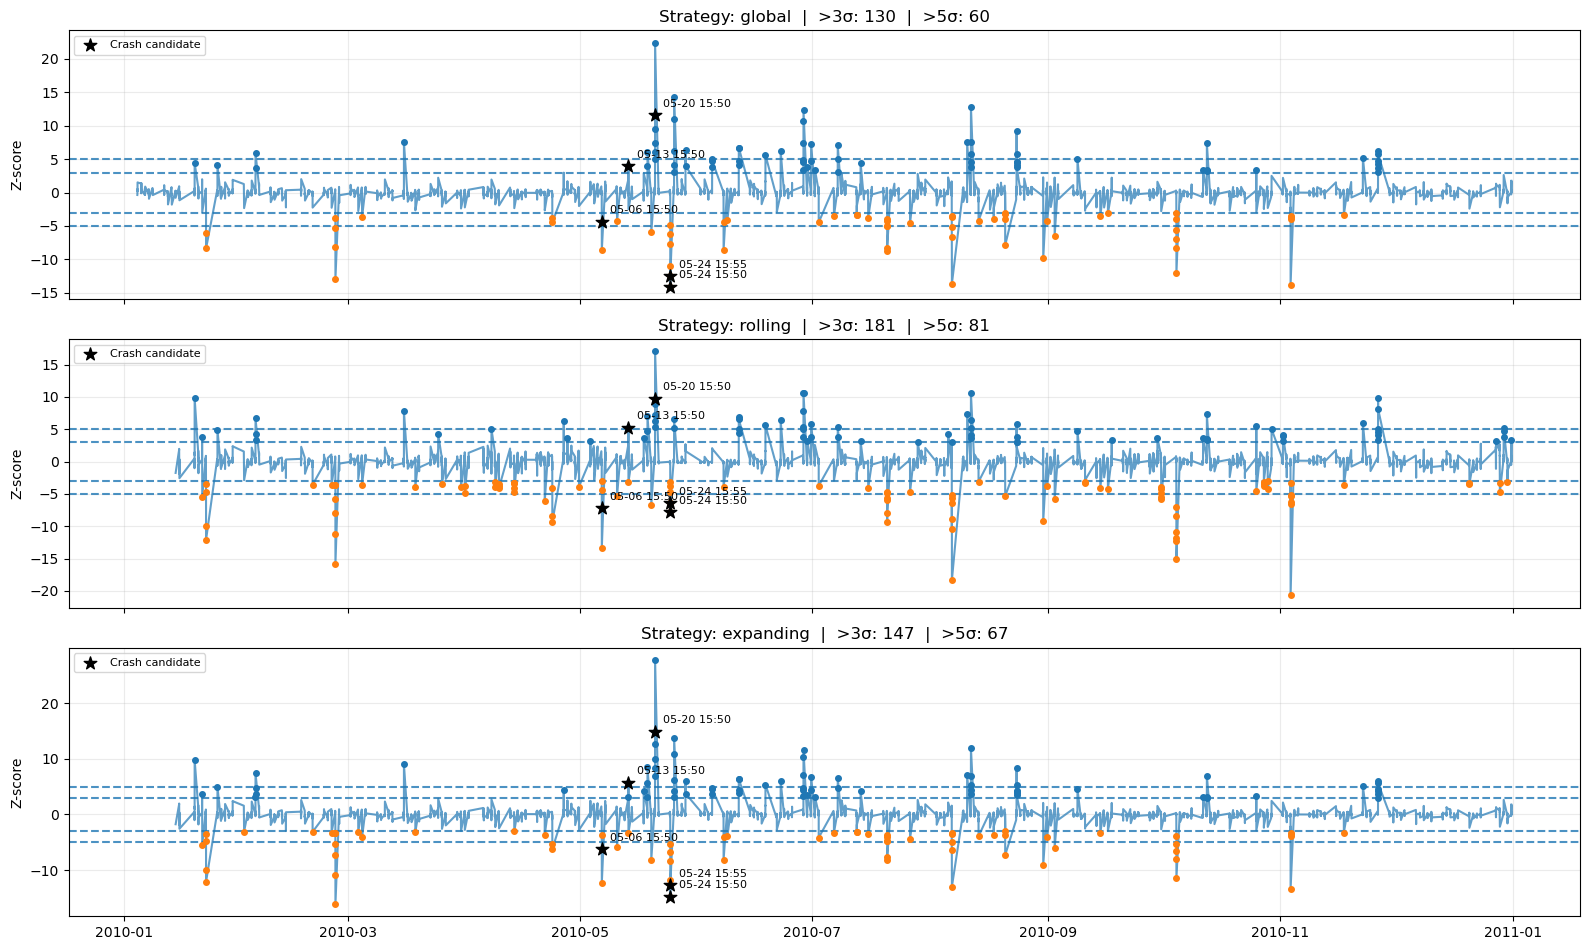

In [54]:
strategies = [
    "global",
    "rolling",
    "expanding",
]

sigma_3 = 3
sigma_5 = 5

COMMON_KWARGS = dict(
    window=390,       
    min_periods=200,
    shift=1,
)

fig, axes = plt.subplots(len(strategies), 1, figsize=(16, 3.2 * len(strategies)), sharex=True)

for ax, strat in zip(axes, strategies):

    scored, outliers_3_pos, outliers_5_pos, outliers_3_neg, outliers_5_neg = method1(
        pdf,
        strategy=strat,
        sigma_warn=sigma_3,
        sigma_alarm=sigma_5,
        **COMMON_KWARGS,
    )
    
    df_m1, cand_m1 = crash_and_flashcrash_filter(
        scored,
        method="m1",
        z_col="fragility_score",
        z_th=3.0,
        drop_th=-0.03,
    )

    print("Strategy", strat)
    print("M1 candidates:", len(cand_m1))
    print(cand_m1[["fragility", "mid_5m", "drop_k", "recovery_frac"]].head(10))
    print("----------------------")

    ax.plot(scored.index, scored["fragility_score"], alpha=0.7)

    
    ax.axhline(sigma_3, linestyle="--", alpha=0.8)
    ax.axhline(sigma_5, linestyle="--", alpha=0.8)
    ax.axhline(-sigma_3, linestyle="--", alpha=0.8)
    ax.axhline(-sigma_5, linestyle="--", alpha=0.8)

    ax.scatter(outliers_3_pos.index, outliers_3_pos["fragility_score"], s=16, zorder=3)
    ax.scatter(outliers_3_neg.index, outliers_3_neg["fragility_score"], s=16, zorder=3)
    
    if len(cand_m1) > 0:
        ax.scatter(
            cand_m1.index,
            scored.loc[cand_m1.index, "fragility_score"],
            s=90,
            marker="*",
            c="black",
            zorder=10,
            label="Crash candidate"
        )

        for ts in cand_m1.index:
            ax.annotate(
                ts.strftime("%m-%d %H:%M"),
                (ts, scored.loc[ts, "fragility_score"]),
                textcoords="offset points",
                xytext=(6, 6),     
                fontsize=8,
                color="black"
            )

        ax.legend(loc="upper left", fontsize=8)
        
    ax.set_ylabel("Z-score")
    ax.set_title(f"Strategy: {strat}  |  >{sigma_3}σ: {len(outliers_3_pos) + len(outliers_3_neg)}  |  >{sigma_5}σ: {len(outliers_5_pos) + len(outliers_5_neg)}")

    ax.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

Method: We established a baseline for "normal" market behavior by analyzing the distribution of the Price Response Function ($R_{\tau}$) across the entire year. We calculated the Z-Score for every 30-minute interval, which measures how many standard deviations a data point is from the yearly mean. We applied statistical thresholds of $3\sigma$ (warning) and $5\sigma$ (critical) to flag anomalies.

### Method 2 - Multivariate Thresholding - Mahalanobis Distance

In [46]:
from sklearn.covariance import MinCovDet

def method2(
    pdf: pd.DataFrame,
    X_scaled: np.ndarray,
    fit_strategy: str = "global",        
    threshold_strategy: str = "global_percentile",  
    window: int = 2000,                    
    min_periods: int = 500,                
    refit_every: int = 50,                
    percentile: float = 99.0,
    random_state: int = 42,
    shift: int = 1,                       
):

    out = pdf.copy()
    n = X_scaled.shape[0]
    scores = np.full(n, np.nan)

    if fit_strategy == "global":
        cov_est = MinCovDet(random_state=random_state).fit(X_scaled)
        scores = cov_est.mahalanobis(X_scaled)

    elif fit_strategy in {"rolling", "expanding"}:
        # Rolling/expanding refit of MinCovDet on past-only data. We refit every `refit_every` steps and reuse in between.
        cov_est = None

        for t in range(n):
            if t < min_periods:
                continue

            if fit_strategy == "rolling":
                start = max(0, t - window)
            else: 
                start = 0

            if (cov_est is None) or (t % refit_every == 0):
                cov_est = MinCovDet(random_state=random_state).fit(X_scaled[start:t])

            scores[t] = cov_est.mahalanobis(X_scaled[t:t+1])[0]

    else:
        raise ValueError(f"Unknown fit_strategy: {fit_strategy}")

    out["anomaly_score"] = scores

    # Thresholding
    if threshold_strategy == "global_percentile":
        valid = out["anomaly_score"].dropna()
        thr_series = pd.Series(np.nan, index=out.index)
        thr_value = np.percentile(valid, percentile) if len(valid) else np.nan
        thr_series.loc[:] = thr_value

    elif threshold_strategy == "rolling_percentile":
        # Dynamic threshold based on past window of scores
        thr_series = (
            out["anomaly_score"]
            .rolling(window=window, min_periods=min_periods)
            .quantile(percentile / 100.0)
            .shift(shift)
        )
        thr_value = thr_series.dropna().iloc[-1] if thr_series.notna().any() else np.nan

    elif threshold_strategy == "expanding_percentile":
        # Dynamic threshold based on all past scores
        thr_series = (
            out["anomaly_score"]
            .expanding(min_periods=min_periods)
            .quantile(percentile / 100.0)
            .shift(shift)
        )
        thr_value = thr_series.dropna().iloc[-1] if thr_series.notna().any() else np.nan

    else:
        raise ValueError(f"Unknown threshold_strategy: {threshold_strategy}")

    out["threshold"] = thr_series
    anomalies_dist = out[out["anomaly_score"] > out["threshold"]]

    return out, anomalies_dist, thr_value

In [47]:

configs = [
    # (fit_strategy, threshold_strategy, title)
    ("global",   "global_percentile",   "Global fit + Global 99% threshold"),
    ("rolling",  "rolling_percentile",  "Rolling fit + Rolling 99% threshold (past-only)"),
    ("expanding","expanding_percentile","Expanding fit + Expanding 99% threshold (past-only)"),
    
    # We could also mix different combinations
    # ("global",   "rolling_percentile",  "Global fit + Rolling 99% threshold"),
    # ("rolling",  "global_percentile",   "Rolling fit + Global 99% threshold"),
]

COMMON_KWARGS = dict(
    window=2000,
    min_periods=500,
    refit_every=50,     
    percentile=99.0,
    random_state=42,
    shift=1,          
)

M2 candidates: 3
                     fragility  mid_5m    drop_k  recovery_frac
timestamp                                                      
2010-05-20 15:50:00  11.561669  42.105 -0.040791       0.930131
2010-05-24 15:50:00 -14.080732  42.275 -0.047191       0.238095
2010-05-24 15:55:00 -12.544424  42.275 -0.048847       0.266344
M2 candidates: 3
                     fragility  mid_5m    drop_k  recovery_frac
timestamp                                                      
2010-05-20 15:50:00  11.561669  42.105 -0.040791       0.930131
2010-05-24 15:50:00 -14.080732  42.275 -0.047191       0.238095
2010-05-24 15:55:00 -12.544424  42.275 -0.048847       0.266344
M2 candidates: 3
                     fragility  mid_5m    drop_k  recovery_frac
timestamp                                                      
2010-05-20 15:50:00  11.561669  42.105 -0.040791       0.930131
2010-05-24 15:50:00 -14.080732  42.275 -0.047191       0.238095
2010-05-24 15:55:00 -12.544424  42.275 -0.048847     

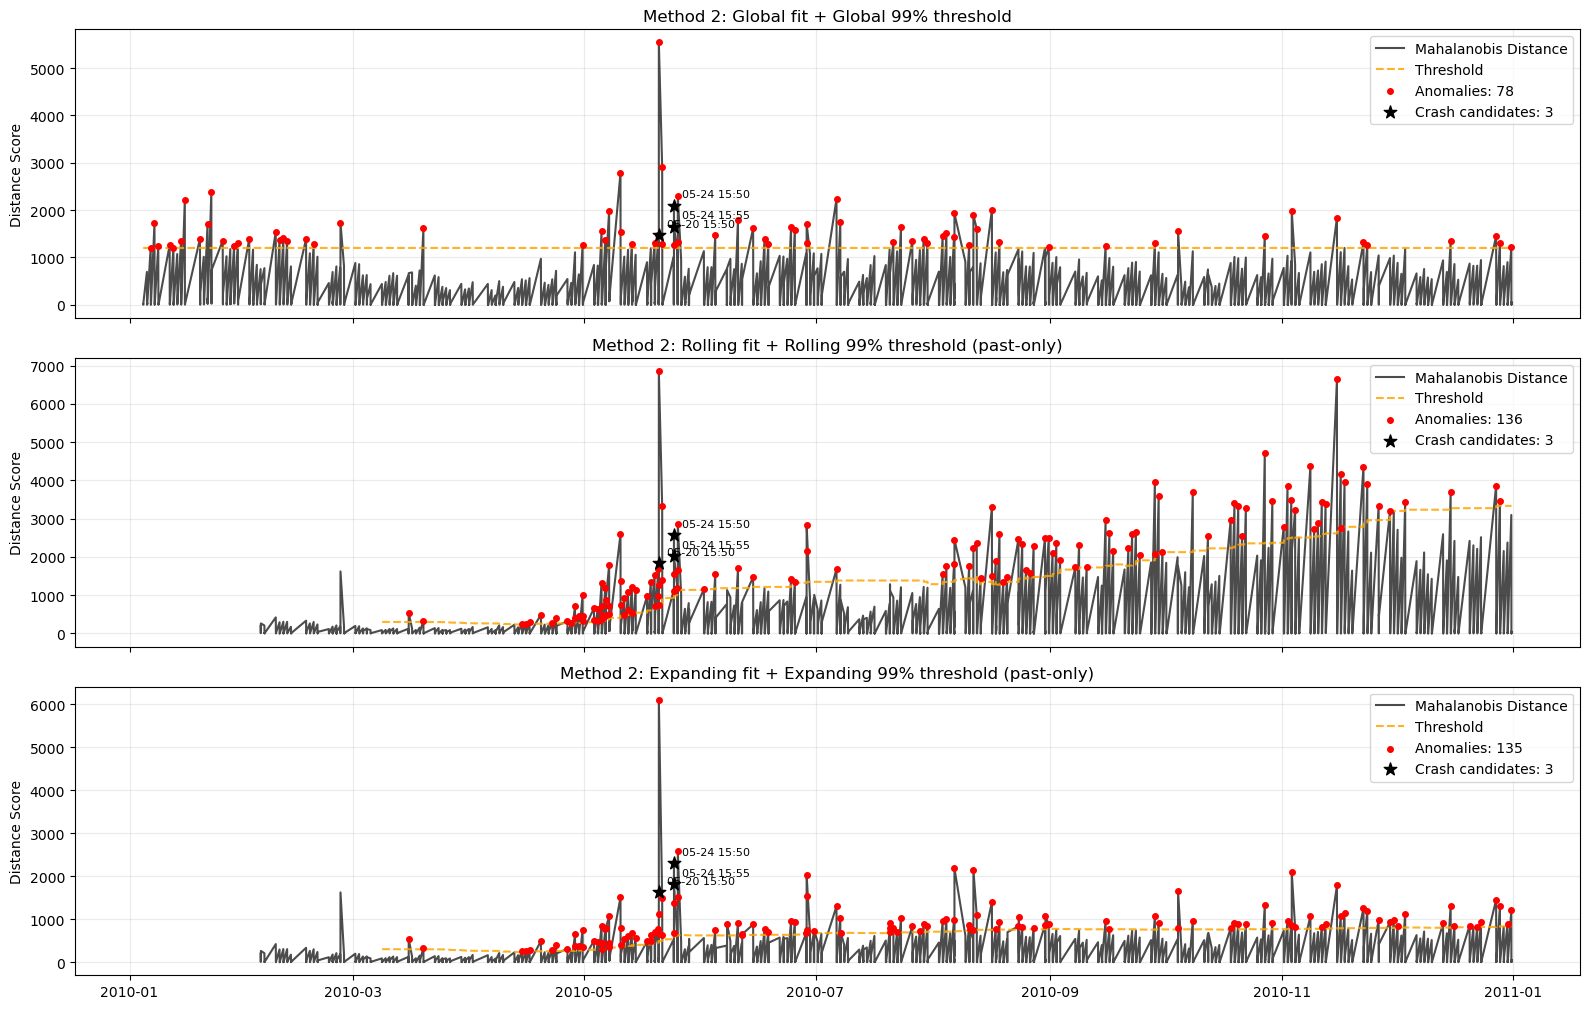

In [48]:
fig, axes = plt.subplots(len(configs), 1, figsize=(16, 3.4 * len(configs)), sharex=True)

if len(configs) == 1:
    axes = [axes]

for ax, (fit_strategy, thr_strategy, title) in zip(axes, configs):
    pdf2, anomalies_dist, thr_last = method2(
        pdf_scaled,
        X_scaled,
        fit_strategy=fit_strategy,
        threshold_strategy=thr_strategy,
        **COMMON_KWARGS,
    )
    
    df_m2, cand_m2= crash_and_flashcrash_filter(
        pdf2,
        method="m2",
        anomaly_col="anomaly_score",
        thr_col="threshold",
        drop_th=-0.03,
        recovery_frac=0.5,
    )
    
    print("M2 candidates:", len(cand_m2))
    print(cand_m2[["fragility", "mid_5m", "drop_k", "recovery_frac"]].head(10))

    ax.plot(pdf2.index, pdf2["anomaly_score"], color="black", alpha=0.7, label="Mahalanobis Distance")
    ax.plot(pdf2.index, pdf2["threshold"], color="orange", linestyle="--", alpha=0.85, label="Threshold")

    ax.scatter(
        anomalies_dist.index,
        anomalies_dist["anomaly_score"],
        color="red",
        s=16,
        zorder=3,
        label=f"Anomalies: {len(anomalies_dist)}",
    )
    
    if len(cand_m2) > 0:
        ax.scatter(
            cand_m2.index,
            pdf2.loc[cand_m2.index, "anomaly_score"],
            s=90,
            marker="*",
            c="black",
            zorder=10,
            label=f"Crash candidates: {len(cand_m2)}"
        )

        cand_to_label = cand_m2.nsmallest(5, "drop_k")

        for ts in cand_to_label.index:
            ax.annotate(
                ts.strftime("%m-%d %H:%M"),
                (ts, pdf2.loc[ts, "anomaly_score"]),
                textcoords="offset points",
                xytext=(6, 6),
                fontsize=8,
                color="black"
            )

    ax.set_title(f"Method 2: {title}")
    ax.set_ylabel("Distance Score")
    ax.grid(True, alpha=0.25)

    ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

Method: Multivariate Anomaly Detection - Mahalanobis Distance: What We did is instead of looking at a single variable, we analyzed the relationship between three key market variables: Volatility, Liquidity, and Fragility ($R_{\tau}$). We used the Mahalanobis Distance to calculate a "Systemic Risk Score" for every timestamp. This method measures how "weird" a combination of variables is, e.g., high volatility is normal if spreads widen, but abnormal if spreads stay tight. We set a 99th percentile threshold to identify structural breaks.

### Method 3 - K-means Clustering

In [12]:
from sklearn.cluster import KMeans

def method3(
    pdf: pd.DataFrame,
    X_scaled: np.ndarray,
    scaler,
    feature_cols,
    fit_strategy: str = "global",
    n_clusters: int = 3,
    window: int = 2000,
    min_periods: int = 500,
    refit_every: int = 200,
    random_state: int = 42,
    n_init: int = 10,
):
    out = pdf.copy()
    n = X_scaled.shape[0]

    clusters = np.full(n, np.nan)
    centers = None
    kmeans = None

    if fit_strategy == "global":
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init)
        clusters = kmeans.fit_predict(X_scaled)

        centers = pd.DataFrame(
            scaler.inverse_transform(kmeans.cluster_centers_),
            columns=feature_cols
        )

    elif fit_strategy in {"rolling", "expanding"}:
        for t in range(n):
            if t < min_periods:
                continue

            start = max(0, t - window) if fit_strategy == "rolling" else 0

            if (kmeans is None) or (t % refit_every == 0):
                kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init)
                kmeans.fit(X_scaled[start:t])
                centers = pd.DataFrame(
                    scaler.inverse_transform(kmeans.cluster_centers_),
                    columns=feature_cols
                )

            clusters[t] = kmeans.predict(X_scaled[t:t+1])[0]

        clusters = clusters.astype(float)

    else:
        raise ValueError(f"Unknown fit_strategy: {fit_strategy}")

    out["cluster"] = clusters

    assigned = out.dropna(subset=["cluster"]).copy()
    assigned["cluster"] = assigned["cluster"].astype(int)

    crash_cluster_id = None
    if centers is not None and "fragility" in centers.columns:
        crash_cluster_id = int(centers["fragility"].idxmax())

    return out, centers, crash_cluster_id

In [60]:
FEATURE_COLS = ['fragility', 'volume', 'liquidity', 'volatility']  

# We have global, rolling, expanding
fit_strategy = "rolling"

pdf3, cluster_centers, crash_cluster_id = method3(
    pdf_scaled,
    X_scaled,
    scaler=scaler,
    feature_cols=FEATURE_COLS,
    fit_strategy=fit_strategy,
    n_clusters=3,
    window=2000,
    min_periods=500,
    refit_every=200,
    random_state=42,
    n_init=10,
)

print(f"Identified Cluster {crash_cluster_id} as 'Crash Regime'.")
print("Cluster Centers (Average Values per Regime):")
print(cluster_centers)

c:\Users\cs157\miniconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\cs157\miniconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\cs157\miniconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\cs157\miniconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans 

Identified Cluster 2 as 'Crash Regime'.
Cluster Centers (Average Values per Regime):
   fragility    volume  liquidity    volatility
0   0.003126  0.041948   0.012584  35842.822414
1   0.003979  0.078147   0.016772  72986.219814
2   0.004461  0.066235   0.029743  33452.365979


c:\Users\cs157\miniconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [61]:
df_m3, cand_m3 = crash_and_flashcrash_filter(
    pdf3,
    method="m3",
    cluster_col="cluster",
    crash_cluster_id=crash_cluster_id,
)

print("M3 candidates:", len(cand_m3))
print(cand_m3[["fragility", "mid_5m", "drop_k", "recovery_frac"]].head(10))

M3 candidates: 1
                     fragility  mid_5m   drop_k  recovery_frac
timestamp                                                     
2010-05-07 15:50:00  -0.025127    44.2 -0.03224        2.34386


# The 2D graph doesn't show well the actual distribution of datapoints since we used 4 features, instead we use multiple 3D graph

In [62]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

features = ['fragility', 'volume', 'liquidity', 'volatility']

cluster_series = pdf3['cluster']

WARMUP_ID = -1
cluster_clean = cluster_series.copy()

if cluster_clean.isna().any():
    cluster_clean = cluster_clean.fillna(WARMUP_ID)

cluster_clean = cluster_clean.astype(int)

unique_clusters = sorted(cluster_clean.unique())

color_map = {}

for cid in unique_clusters:
    if cid == WARMUP_ID:
        color_map[cid] = 'lightgray'        
    elif crash_cluster_id is not None and cid == int(crash_cluster_id):
        color_map[cid] = 'red'             
    elif cid == 0:
        color_map[cid] = 'blue'            
    else:
        color_map[cid] = 'orange'         

pdf3['color'] = cluster_clean.map(color_map)

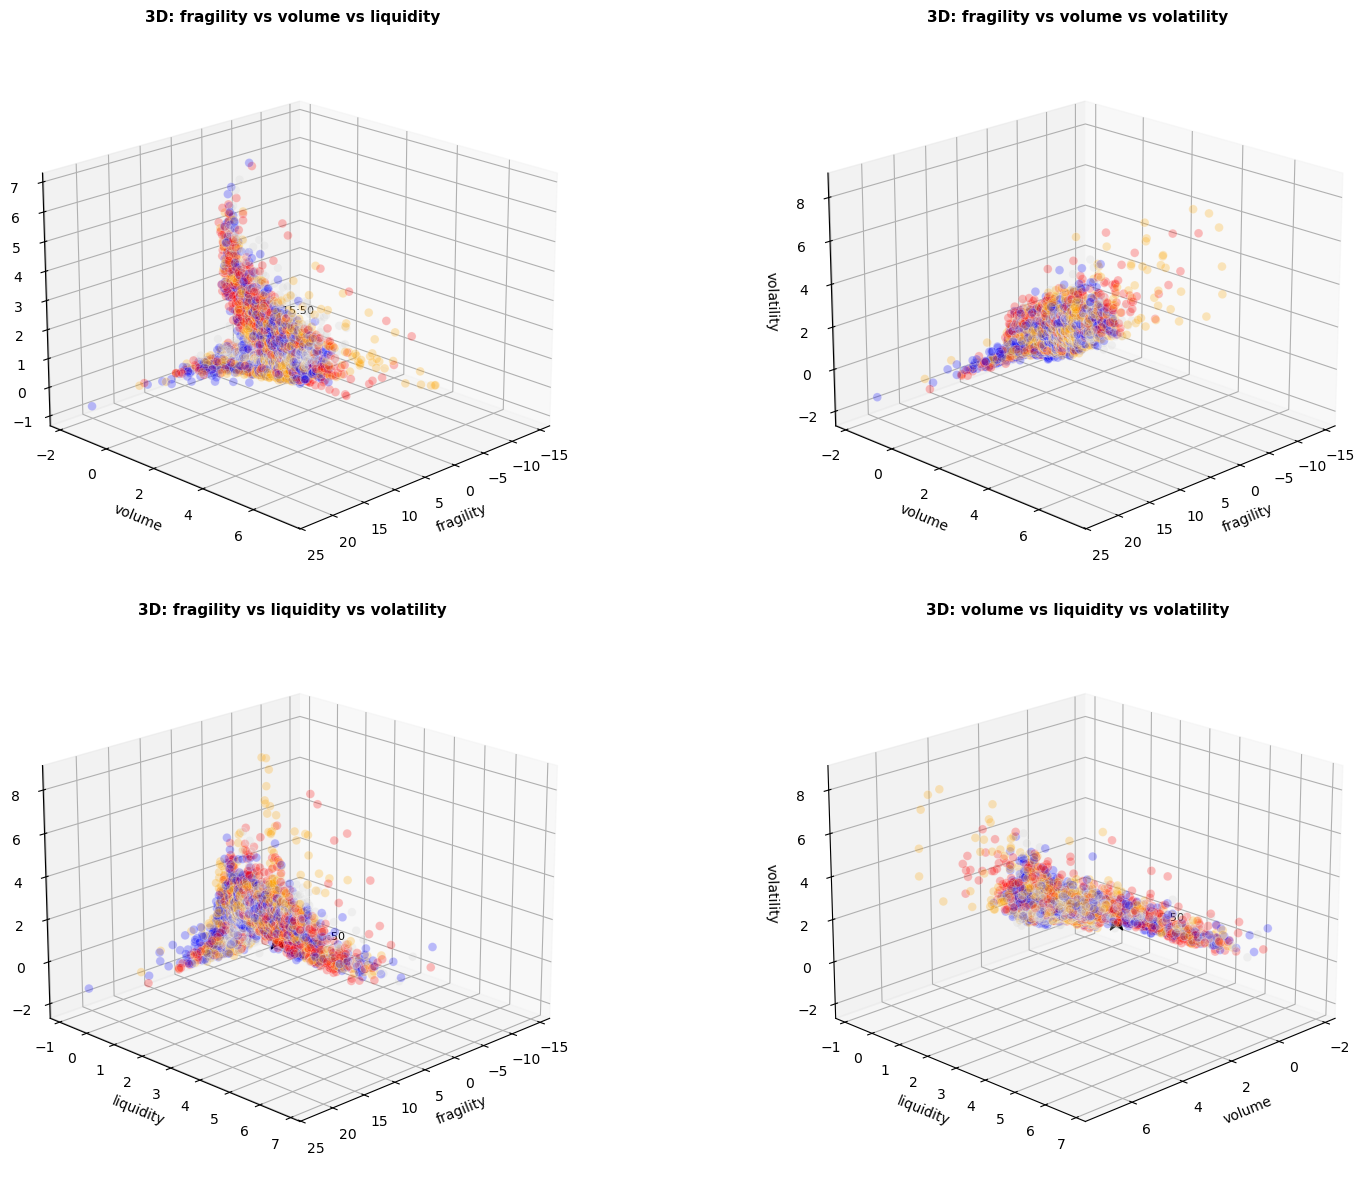

In [63]:
import itertools
from sklearn.decomposition import PCA

features = ['fragility', 'volume', 'liquidity', 'volatility']  

fig = plt.figure(figsize=(18, 12))

triples = list(itertools.combinations(features, 3))

for i, (x_col, y_col, z_col) in enumerate(triples, start=1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    ax.scatter(
        pdf3[x_col],
        pdf3[y_col],
        pdf3[z_col],
        c=pdf3['color'],
        s=40,
        alpha=0.25,
        edgecolors='w',
        linewidth=0.5
    )
    
    ax.scatter(
        cand_m3[x_col], cand_m3[y_col], cand_m3[z_col],
        s=220,
        marker="*",
        c="black",
        alpha=1.0,
        depthshade=False,   
        zorder=99999999,         
        label="Crash candidate"
    )
    
    for ts in cand_m3.index:
        ax.text(
            cand_m3.loc[ts, x_col],
            cand_m3.loc[ts, y_col],
            cand_m3.loc[ts, z_col],
            ts.strftime("%m-%d %H:%M"),
            fontsize=8
        )
        
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_zlabel(z_col)
    ax.set_title(f"3D: {x_col} vs {y_col} vs {z_col}", fontsize=11, fontweight='bold')
    ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

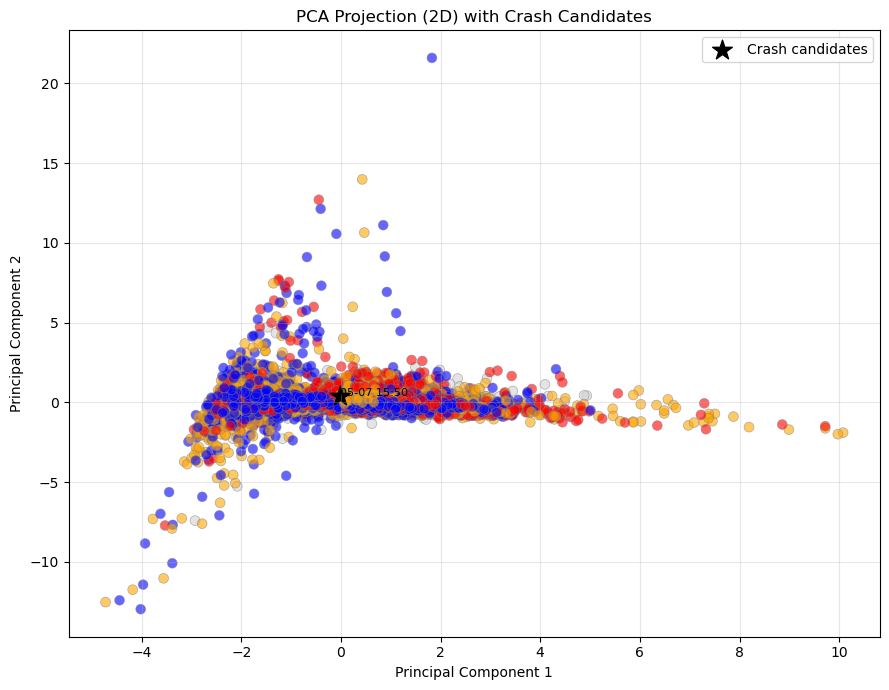

In [64]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(9, 7))

plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=pdf3['color'],
    s=50,
    alpha=0.6,
    edgecolors='gray',
    linewidth=0.5
)

# Overlay the crash candidates
cand_mask = pdf3.index.isin(cand_m3.index)

plt.scatter(
    X_pca[cand_mask, 0],
    X_pca[cand_mask, 1],
    s=220,
    marker="*",
    c="black",
    alpha=1.0,
    label="Crash candidates"
)

# Label crash candidates with timestamp
cand_idx = np.where(cand_mask)[0]
for i in cand_idx:
    ts = pdf3.index[i]
    plt.text(
        X_pca[i, 0],
        X_pca[i, 1],
        ts.strftime("%m-%d %H:%M"),
        fontsize=8
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection (2D) with Crash Candidates')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Method: We applied K-Means Clustering ($k=3$) to the dataset to automatically group market conditions into distinct "Regimes". Crucially, this was a "blind" detection—we did not tell the algorithm when the crash happened or what a crash looks like. We simply asked it to group similar data points together.